In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import baseline_classifier as bsclf
%matplotlib inline

# Table of content
* [1 Description of the assignment](#Introduction)
* [2 The data](#TheData)
* [3 Loading the data](#LoadingTheData)
* [4 Exploratory data analysis](#ExploratoryDataAnalysis)
    * [4.1 How many bank entries do companies have?](#HowManyBankEntries)
    * [4.2 How many accounts do companies have?](#HowManyAccounts)
    * [4.3 How many bank entries are there per account?](#HowManyBankEntriesPerAccount)
    * [4.4 Summary of exploratory data analysis](#SummaryOfExploratory)
* [5 Looking into a single company in more detail](#SingleCompanyExploratory) 
    * [5.1 Selecting the data for the company ID int:7cb070e](#selectingDataForSingle)
    * [5.2 How many bank entries does the company have?](#howManyBankEntries)
    * [5.3 How many of the bank entry texts are unique?](#HowManyBankEntriesAreUnique)
    * [5.4 How many accounts does the company have?](#HowManyAccountsDoeThisHave)
    * [5.5 How are the bank entries distributed across the different accounts?](#HowAreTheyDistributed)
* [6 Building the baseline classifier](#BuildingTheBaselineClassifier) (Part 1)
    * [Establishing the probabilities](#EstablishingTheProbabilities)
* [7 Testing the baseline classifier](#TestingTheBaselineClassifier)
    * [7.1 Testing on a single company](#TestingTheBaselineClassifierOnSingle)
    * [7.2 Testing the classifier on each company](#TestingTheBaselineClassifierOnAll)
    * [7.3 Summary of the baseline classifier](#SummaryOfTheBaselineClassifier)
    * [7.4 Ideas for improving on the baseline classifier](#ImprovingOnTheBaselineClassifier)
* [8 Taking advantage of the data across different companies](#TheSecondPart) (Part 2)
    * [8.1 Abstraction: Mapping text onto features](#MappingText)

# 1. Description of the assignment<a id='Introduction'></a>
This is my solution to the hiring assignment e-conomics posed the candidates applying for a position as a Data Scientist on the machine learning team. The assignment is descibed in detail [here](https://github.com/e-conomic/hiring-assigments/tree/master/autosuggest/bankrec-assignment).

In short, the assignment is to build a classifier that that can predict which account a given bank entry should be filed under. The assignment is divided into two parts. In the first part the candidate is asked to build and test a classifier __for each__ company. In the second part the candidate is asked to reflect on how one could build a classifier that works __for all__ companies. This would greatly increase the amount of training data and (perhaps) simply the process of classifying the bank entries.

# 2. The data<a id='TheData'></a>
The dataset consist of expenses from 100 random companies. For each company all expenses  booked in e-conomic are provided, totaling in 737017 bank entries. For each bank entry the following details are included as columns in the dataset:
* **CompanyId**: The identifyer of the company to help you slice and dice the data in the right way.
* **BankEntryDate (feature)**: The date of the financial transaction.
* **BankEntryText (feature)**: The text following along with the financial transaction. This is typically machine generated, but in case of manual transactions they may be manually written by a human.
* **BankEntryAmount (feature)**: The amount of the financial transaction. Expenses are negative, earnings are positive.
* **AccountNumber (target)**: The account number. The uniquely identifies an account, and can therefore be used as the target variable / the class that we want to predict.
* **AccountName**: The name of the account.
* **AccountTypeName**: The type of the account.

# 3. Loading and inspecting the data<a id='LoadingTheData'></a>
The data are provided as a csv file and I load it using Pandas.

In [2]:
data = pd.read_csv('data/bank_expenses_obfuscated.csv')
print(data.shape)

(737017, 8)


We have 737017 entries.

Let's look at the first 5 rows of the dataframe.

In [3]:
data[0:5]

,Unnamed: 0,CompanyId,BankEntryDate,BankEntryText,BankEntryAmount,AccountName,AccountNumber,AccountTypeName
0,0,int:a055470,2016-02-29,str:6cd08e4 int:49fed34,> -1000,str:1e82557,9900,Balance
1,1,int:a055470,2016-02-29,str:6cd08e4 int:49fed34,> -1000,str:9ce853c,3115,Profit and Loss
2,2,int:a055470,2016-02-29,str:38248d2,> -100,str:a9f0788,2240,Profit and Loss
3,3,int:a055470,2016-02-29,str:38248d2,> -100,str:1e82557,9900,Balance
4,4,int:a055470,2016-02-29,str:c704d91 str:1b0ad3b str:2598b78 str:070dddb,> -10000,str:a67d2b5,2270,Profit and Loss


# 4 Exploratory data analysis<a id='ExploratoryDataAnalysis'></a>
The goal is to get a better understanding of the data before I build a simple classifier that can work as a baseline for more complicated classifiers. Each subsection will deal with a specific question I have about the data.

## 4.1 How many bank entries do the companies have? <a id='HowManyBankEntries'></a>
Since the input to the classifier will be bank entries, I should understand how many entries each company has. This way, I can get an idea about how data intensive I can allow the classifiers to be. 

Below I find the unique company IDs and loop over them to find the total number of bank entries for each company.

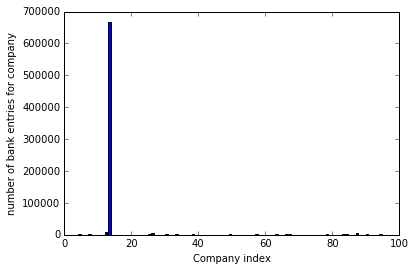

In [4]:
companies = data['CompanyId'].unique()
num_bank_entries_pr_company = np.zeros((100,1))

for idx, company in enumerate(companies):
    num_bank_entries_pr_company[idx] = data[data.CompanyId==company].count()[0]
    
plt.bar(range(0,100),num_bank_entries_pr_company)
plt.xlabel('Company index')
plt.ylabel('number of bank entries for company')

So by far the majority of bank entries are located with just a single company! This happens to be the 13th company in the list:

In [5]:
print(num_bank_entries_pr_company[13])

[ 667021.]


So just one of the companies has **about 90 of the entire dataset!**

Let have a closer look at some of the other companies: 

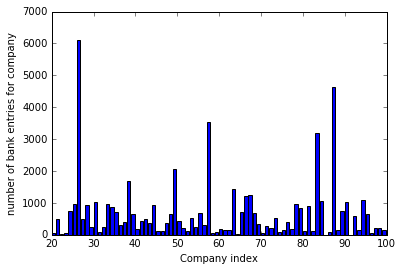

In [6]:
plt.bar(range(20,100),num_bank_entries_pr_company[20:100])
plt.xlabel('Company index')
plt.ylabel('number of bank entries for company')

It appears that it is much more common to have close to 1000 entries or less. So I won't have as much data per company as I initially thought.

## 4.2 How many accounts do the companies have? <a id='HowManyAccounts'></a>
Since I am building a classifier for each company it is important to know how many accounts each company has. This is also important for the second part of the assigment, since builder a classifier that works for all companies might be difficult if the number of accounts varies a lot between companies.

Below I show the number of accounts for each company.

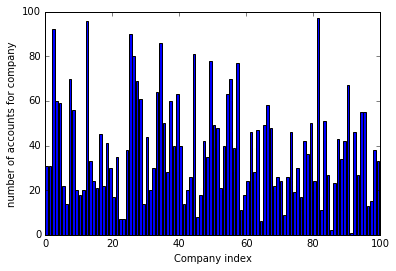

In [7]:
num_accounts_pr_company = np.zeros((100,1))
for idx, company in enumerate(companies):
    company_data = data[data.CompanyId==company]
    num_accounts_pr_company[idx] = len(company_data['AccountNumber'].unique())
    
plt.bar(range(0,100),num_accounts_pr_company)
plt.xlabel('Company index')
plt.ylabel('number of accounts for company')

The number of accounts the companies have vary greatly.

A histogram of the number of accounts makes this point more clearly.

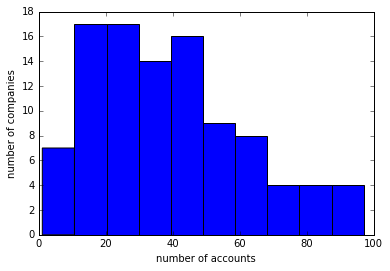

In [8]:
plt.hist(num_accounts_pr_company)
plt.xlabel('number of accounts')
plt.ylabel('number of companies')

Most companies have between 10 and 50 accounts. With so many accounts building a classifier for each account for each company may be a good idea.

## 4.3 Do companies with more bank entries also have more accounts?<a id='HowManyBankEntriesPerAccount'></a>
Ok. So the number of bank entries and accounts vary between companies. If companies with more accounts also have more bank entries, it might make classification easier. Let's have a look:

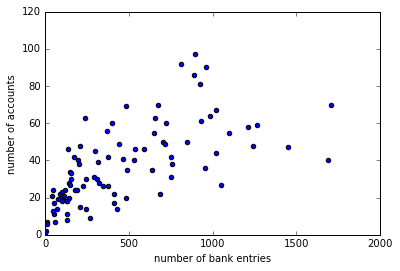

In [9]:
plt.scatter(num_bank_entries_pr_company, num_accounts_pr_company)
plt.axis([0, 2000, 0, 120])
plt.xlabel('number of bank entries')
plt.ylabel('number of accounts')

So it does seem that there is a correlation between number of accounts and number of bank entries, but there is a lot of variability. 

How many bank entries are there per account on average?

[0, 100, 0, 20]

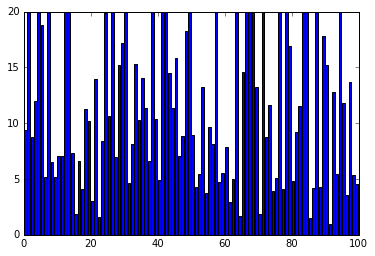

In [10]:
bank_entries_per_account_for_each_company = num_bank_entries_pr_company / num_accounts_pr_company
plt.bar(range(0,100),bank_entries_per_account_for_each_company)
plt.axis([0, 100, 0, 20])

Aparrently a lot of the companies have fewer than 10 bank entries per account. This means that if we want to train a classifier per account per company, we had better use a classification model that does not need a lot of data to give good results.

## 4.4 Summary of exploratory data analysis<a id='SummaryOfExploratory'></a> 
* The data contains 100 companies, and 737017 bank entries. Of these **90% (667021/737017) are from a single company!** It is much more common for a company to have close to 1000 bank entries.
* Many companies have **between 10 and 50 accounts**.
* Many of the companies have **fewer than 10 bank entries per account**, on average.

## 5 Looking at a single company in more detail<a id='SingleCompanyExploratory'></a>
Above I look into the distribution of bank entries and bank accounts across the different companies. This gave a rough idea about what to expect from the data. However, since we are building a classifier for each company, understanding how the bank entries are distributed across the accounts within a company is important.

Therefore I will look at the data for a single company in more detail. I will use company **int:7cb070e** as an example.

I am looking for the answer to the following questions:
* How many of the bank entry texts are unique?
* How are the bank entries distributed across the different accounts?

## 5.1 Selecting the data for the company ID int:7cb070e<a id='selectingDataForSingle'>
Here I load the data from the company.

In [11]:
company_df = data[data.CompanyId=='int:7cb070e']
company_df[0:5]

,Unnamed: 0,CompanyId,BankEntryDate,BankEntryText,BankEntryAmount,AccountName,AccountNumber,AccountTypeName
1041,0,int:7cb070e,2016-06-29,str:0910abd str:325c669 str:acbadfb int:e14c8e7,> -10000,str:40b14b3,1310,Profit and Loss
1042,1,int:7cb070e,2016-06-29,str:4a5eaad str:640555d,> -10000,str:3a4a6a4,1321,Profit and Loss
1043,2,int:7cb070e,2016-06-28,str:1977f5c,> -100,str:d5770eb,2350,Profit and Loss
1044,3,int:7cb070e,2016-06-28,str:6086f71,> -10000,str:40b14b3,1310,Profit and Loss
1045,4,int:7cb070e,2016-06-27,str:2147693,> -10000,str:40b14b3,1310,Profit and Loss


## 5.2 How many bank entries does the company have?<a id='howManyBankEntries'>

In [12]:
company_df.shape

(808, 8)

So the company has a total of **808 bank entries**.

## 5.3 How many of the bank  entry texts are unique?<a id='HowManyBankEntriesAreUnique'></a>
The number of distinct bank entry text is important because I would like to use this feature for the baseline classifier.

Finding the unique **BankEntryText** for the Company:

In [13]:
unique_bank_entry_texts = company_df['BankEntryText'].unique()
print(len(unique_bank_entry_texts))

320


Since the company has a total of **808 bank entries**, finding that **320 of them are distinct** is ok. Since there are only 320 different bank entry text there are bound to be some dublicates.

## 5.4 How many accounts does the company have?<a id='HowManyAccountsDoeThisHave'></a>

In [14]:
unique_account_numbers = company_df['AccountNumber'].unique()
print(len(unique_account_numbers))

92


The company has **92 accounts**. This means that, on average, I will have fewer than 10 data points per account. Furthermore, I will only have about 3 distinct bank entry texts, on average. But let us look into the distribution of bank entry texts in more detail.

## 5.5 How are the bank entries distributed across the different accounts?<a id='HowAreTheyDistributed'></a>

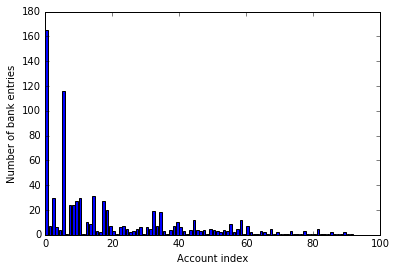

In [15]:
bank_entries_per_account = np.zeros(unique_account_numbers.shape)
for idx, account in enumerate(unique_account_numbers):
    bank_entries_per_account[idx] = company_df[company_df.AccountNumber==account].count()[0]
    
plt.bar(range(0,len(unique_account_numbers)), bank_entries_per_account)
plt.xlabel('Account index')
plt.ylabel('Number of bank entries')

It appears that most of the bank entries are filed under just a few of the accounts. This means that if I can get a classifier to work for the most popular accounts I will be able to get a decent accuracy from the classifier. But it may be difficult to classify corrently into the accounts with 5 or less bank entries.

# 6 Building a baseline classifier<a id='BuildingTheBaselineClassifier'></a>
The exploratory analysis presented above suggests that a reasonable baseline would be to establish the frequency of each **speciic** bank entry going into a spefic account. That is, I want to calculate the following: Given a **BankEntryText** what is the probability that it is classified as **AccountNumber**. When I have this probability for each **AccountNumber**, I can use the highest probability as my classifier. This only works whenever I encounter a **BankEntryText** that is allready in the training data, of course. 

The classifier basically says: Put the bank entry where you usually put it. It will not be perfect and it only uses a single feature, but it is a reasonable baseline. Any classification system I build should at least be able to beat this raw probabalistic appraoch.

For this I will continue to use the company with Conpanyid **int:a055470**

## 6.1 Etablishing the probabilities<a id='EstablishingTheProbabilities'></a>
I will use the following vectorization: I create a matrix containing the unique bank entries as rows and the bank accounts as columns. 

The simplest version of the classifier takes the maximum of the elements for each row in the matrice and classifies the **unique BankEntry** as belonging to that account.

Below I build up this matrix:

In [16]:
my_matrix = np.zeros((len(unique_bank_entry_texts),len(unique_account_numbers)))
for idx, bank_entry_text in enumerate(unique_bank_entry_texts):
    temp = company_df[company_df.BankEntryText == bank_entry_text]
    temp_account_numbers = temp['AccountNumber']
    for account in temp_account_numbers:
        account_index = unique_account_numbers == account
        my_matrix[idx, :] = my_matrix[idx, :] + account_index

Let's have a look at the matrix

In [17]:
my_matrix

array([[  1.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   1.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,  30., ...,   0.,   0.,   0.],
       ..., 
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   1.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

So now I have established a matrix containing the information I want. For each **unique BankEntryText** it tell us which accounts these bank entries have been classified to. Do some of the **unique BankEntries** go to different accounts? Let us have a closer look:

In [18]:
my_matrix[5,:]

array([ 9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

So some of the **unique BankEntries** do indeed go to different accounts.

# 7. Testing the baseline classifier <a id='TestingTheBaselineClassifier'></a> 
## 7.1 Testing on a single company <a id='TestingTheBaselineClassifierOnSingle'></a>
The baseline classifier is implemented in `baseline_classifier.py`. Here I use it on a single company.

In [19]:
company_id = 'int:7cb070e'
company_df = data[data.CompanyId == company_id]
train_size, test_size, num_correct_predictions, accuracy = bsclf.baseline_classifier(company_df)
print('Number of test cases is: ' + str(test_size))
print('number of correct predictions is: ' + str(num_correct_predictions))
print('The accuracy is: ' + str(accuracy))

Number of test cases is: 162
number of correct predictions is: 100.0
The accuracy is: 0.617283950617


baseline_classifier.py:83: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  classifier[bank_entry] = unique_account_numbers[max_element_idx[counter]]


For a base line that isn't bad

## 7.2 Testing the classifier on each company<a id='TestingTheBaselineClassifierOnAll'></a>
Above we saw that for the specific company the baseline classifier had an accuracy of 60%. Thats quite ok, but we have allready seen that the number of accounts and bank entries vary a lot between the companies. So how does the baseline do on **every single company?**

Below I run the baseline classifier on every company using 80% of the data is training data. The 80% are the oldest 80 % of the data.

In [20]:
reload(bsclf)

all_test_sizes = np.zeros((100,1))
all_num_correct = np.zeros((100,1))
all_accuracies = np.zeros((100,1))
for idx, company in enumerate(companies):
    company_df = data[data.CompanyId == company]
    train_size, test_size, num_correct, accuracy = bsclf.baseline_classifier(company_df)
    all_test_sizes[idx] = test_size
    all_num_correct[idx] = num_correct
    all_accuracies[idx] = accuracy

Looking at how the accuracy changes with test size:

The average accuracy is: [ 0.42753461]


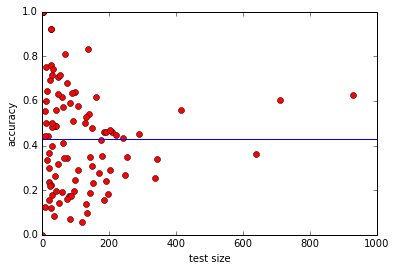

In [21]:
avg_accuracy = sum(all_accuracies)/len(all_accuracies)

plt.plot(all_test_sizes, all_accuracies,'or')
plt.plot([0, 1000],[avg_accuracy, avg_accuracy],'-b')
plt.axis([0, 1000, 0, 1])
plt.xlabel('test size')
plt.ylabel('accuracy')

print('The average accuracy is: ' + str(avg_accuracy))

There is a lot of variability in the accuracy! This is even true for the companies with more than 100 bank entries in the test set. However, above 200 bank entries in the test set the baseline classifier appears to deliver more consistent results. The average accuracy of 42% is not good, but it serves as a fine baseline.

Does it do better when a company has fewer accounts?

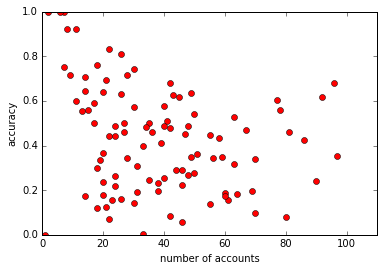

In [22]:
plt.plot(num_accounts_pr_company, all_accuracies,'or')
plt.axis([0, 110, 0, 1])
plt.xlabel('number of accounts')
plt.ylabel('accuracy')

Yes, but again the variability is large.

Below I show a histogram of the accuracy. The histrogram shows clearly that there is a broad distribution of accuracies. So the baseline classifier is not particularly consistent across the companies

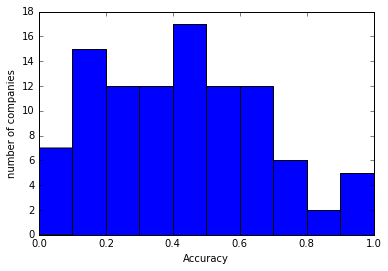

In [23]:
plt.hist(all_accuracies)
plt.ylabel('number of companies')
plt.xlabel('Accuracy')

## 7.3 Summary of the baseline classifier<a id='SummaryOfTheBaselineClassifier'></a>
Using just a single feature the baseline classifier is able to get an average accuracy of 42%

The goal of any improvement to the baseline classifier should be twofold: 1) It should give a narrower distribution of accuracies. This means that different clients will have consistent experiences. 2) It should increase the average accuracy.

## 7.4 Ideas for improving on the baseline classifier<a id='ImprovingOnTheBaselineClassifier'></a>
An obvious approach to improving the classifier is to considre more features. We only have two extra feature to consider. The data of the bank entry and the ammount of the bank entry.

Of these the amount is probably the most promising.

# 8 The second part<a id='TheSecondPart'></a>
Making a classifier that can take advantage of data across different companies might improve the accuracy. It would also help avoid the __cold start__ problem where newcommers to the service have a bad experience because they have no data for us to use.

I was asked to think about how one might solve the problem without actually building a classifier. So below I will outline different approaches to the problem. Exploratory analysis will be included whenever I feel it helps flesh out the idea.

## 8.1 Abstraction: Mapping text onto features<a id='MappingText'></a>
One way to get around this is to build a classifier that is based on the name of the account name rather than the speficic account id. In this way, if a company open up a new account with a title that is allready known we would be able to use the information from other companies. 

The general idea is that the name of the account tells us something about how the account is used. If the name of the account is **transport** then it is probably a good place to file transport related bank entries. If different companies uses the same account names we will be able to use the data across different companies.

This approach require that different companies use accounts with the same names in a similar manner. I was told in the assignment text that this is not neccesarely the case. It also suffers if several accounts have similar names such as **transport for clients**, **transport for employee**.

### 8.1.1 How many different bank accounts names and entry texts are there?

In [24]:
unique_account_names = data['AccountName'].unique()
print('There are ' + str(len(unique_account_names)) + ' different account names')
print('There are ' + str(int(sum(num_accounts_pr_company))) + ' accounts in total') 

unique_bank_entry_texts = data['BankEntryText'].unique()
print('There are ' + str(len(unique_bank_entry_texts)) + ' different bank entry texts')

There are 2075 different account names
There are 3863 accounts in total
There are 46571 different bank entry texts


### 8.1.2 How many bank entries does each account have?

In [25]:
unique_account_bank_entry_counter = np.zeros((len(unique_account_names),1))
for idx, account_name in enumerate(unique_account_names):
    temp_df = data[data.AccountName == account_name]
    unique_account_bank_entry_counter[idx] = len(temp_df)

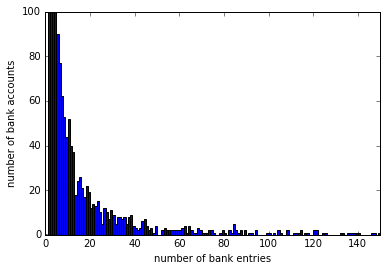

In [26]:
plt.hist(unique_account_bank_entry_counter,bins=range(0,1000,1))
plt.axis([0, 150, 0, 100])
plt.xlabel('number of bank entries')
plt.ylabel('number of bank accounts')

The vast majority of the of the unique bank account names have fewer than 10 bank entries.

So one should focus on the account usage, rahter than the naming. One also has to group similar accounts together. Pooling of the accounts is nescessary to get enough data to train any machine learning algorithm at all.